## 1. Cleaning of Raw Data : Scheme, User, Transactions 


Provided, we have : 
1. User's Portfolio Transactions data 
2. Mutual Fund Metadata
3. Scheme level daily NAV/ returns data

We create a clean, structured view of user portfolios, metadata and daily returns data. 

Transactions CAS (Consolidated account statement) can be fetched directly from MFCentral. And Mutual fund Metadata and returns data is publicly available and published by resp ectiveAsset Management Companies(AMC)/ Fundhouses. 

We have access to 2 and 3 from Morningstar Direct via my organisation. So we use this acccessible data (Metadata and Daily Data) for our analysis below. 
Please Note that Transactions data is encrypted in git and cannot be shared.

We feed user portfolio data for 1000 users and all mutual funds' metadata and returns data. Further we will be restricting usecase to only **direct growth mutual funds.**

Now, we create a cleaned, structured view of user portfolios and mutual funds metadata and returns data: 

---
 **Step 1: Loading Raw Data**
 
We import the following data:
1. `Transactions.csv`: Transactions level data from MF Central (Attributes :USERID,ISIN,TRANSACTION TYPE, UNITS, PURCHASE_PRICE)
2. `Metadata.csv`: (Mutual Fund) ISIN Level data (ISIN, FUND CATEGORY, FUNDTYPE, FUND_NAME, INCEPTION DATE) 
3. `daily_data.csv`: Date, ISIN level data (DATE, ISIN, DAILY NAV)

In [1]:
import pandas as pd
transactions = pd.read_csv("Transactions_2.xls")  # User transactions data 
fund_metadata = pd.read_csv("Metadata.xls")     # Fund-level information
nav_daily = pd.read_csv("daily_data.xls")       # Daily NAV history (past 3 years returns (4 year daily NAV))



**Step 2. Cleaning Transactions Data :**

- We filter for only `SUCCESS` transactions and non-zero `TRANSACTION_UNITS`/  `TRANSACTION_AMOUNT`
- Normalize `DEPOSIT` as +ve, `WITHDRAW` as -ve 
- We retain the useful attributes in `txns_filtered`: `price`, `units`, and `amount`  

This helps us consolidate user's exact hodings per ISIN.

In [2]:
#Filtering Transactions Data :
txns_filtered = transactions[ (transactions["TRANSACTION_STATUS"] == "SUCCESS") &
                             (transactions["TRANSACTION_TYPE"].isin(["DEPOSIT", "WITHDRAW"])) &
                             (transactions["TRANSACTION_UNITS"] != 0 ) ].copy()


#Normalizing deposit as +ve, withdraw as -ve  for units, amount: 
txns_filtered["units"] = txns_filtered.apply(
    lambda row: row["TRANSACTION_UNITS"] if row["TRANSACTION_TYPE"] == "DEPOSIT" else -abs(row["TRANSACTION_UNITS"]),
    axis=1
)
txns_filtered["amount"] = txns_filtered.apply(
    lambda row: row["TRANSACTION_AMOUNT"] if row["TRANSACTION_TYPE"] == "DEPOSIT" else -abs(row["TRANSACTION_AMOUNT"]),
    axis=1
)


txns_filtered["price"] = txns_filtered["PURCHASE_PRICE"]  #unit price for purchase

**Step 3. Creating Scheme-Level data per user (from above cleaned transactions) : User-Level Scheme Summary**
 
We group `txns_filtered` by `USER_ID` and `ISIN` to calculate:
- Total sum(units) held in each mutual fund 
- Total sum(invested amount)
- Average cost price 

This gives us `scheme` (a fund-level snapshot of each user’s portfolio that’s currently active) (units > 0).

In [3]:

import numpy as np

# Function to sum transactions holdings at user,isin level
def aggregate_scheme(group):
    total_units = group["units"].sum()
    total_amount = group["amount"].sum()
    if total_units == 0:
        avg_price = np.nan
    else:
        avg_price = np.average(group["price"], weights=group["units"])
    return {
        "total_units": total_units,
        "total_amount_invested": total_amount,
        "avg_cost_price": avg_price
        
    }


#Running a loop for each (user,isin) group : 

records = []      #helper list
for (user_id, isin), group in txns_filtered.groupby(["USER_ID", "ISIN"]):
    record = aggregate_scheme(group)
    record["USER_ID"] = user_id
    record["ISIN"] = isin
    records.append(record)


# Final PD Dataframe:  Scheme level data (for each user)
scheme = pd.DataFrame(records)
scheme = scheme[scheme["total_units"] > 0]
scheme.head()

,total_units,total_amount_invested,avg_cost_price,USER_ID,ISIN
0,15.107,11999.40,794.300153,User1,INF109K015K4
1,150.356,5999.70,39.903500,User1,INF109K016E5
2,195.616,21998.90,112.460562,User1,INF109K016L0
3,10.138,14999.26,1479.420910,User1,INF179K01YS4
4,396.142,5999.70,15.145300,User1,INF194KB1CR7


**Step 4. Cleaning Metadata Table, Filter Direct Growth Funds**

1.We filter for only Direct Growth Funds
<br>

Each Indian Mutual fund has 2 distribution channels : <br>
i) Regular Funds :Commissions paid out to intermediaries <br>
ii) Direct Funds :Directly from AMC/Fundhouse, and consequently lower expense ratio    (["PURCHASE_MODE"] == 2) <br>
Since we are comfortable with investing on our own strategy, we will consider only direct funds. 


Also usually funds has 2 reinvestment options : <br>
i) Growth : Profits from returns are reinvested (long-term capital accumulated-> compunding returns)   (["DISTRIBUTION_STATUS"] == "Accumulated")
<br>
ii) IDCW (Income Distribution Cum Capital Withdrawal): Regular payouts <br>
Therefore to maximise profits from mutual fund investments over long term (>=3 years), we take only direct growth funds. <br>

2.Also, we remove funds which are less than a year old (as they will not have 1Y returns data yet)


3.Finally, we combine metadata with scheme to get consolidated data for scheme


In [4]:


from datetime import datetime, timedelta

#We remove funds which are less than a year old (as they will not have 1Y returns data yet)
fund_metadata["INCEPTION_DATE"] = pd.to_datetime(fund_metadata["INCEPTION_DATE"], errors="coerce")
cutoff_date = datetime.today() - timedelta(days=365)
fund_metadata = fund_metadata[fund_metadata["INCEPTION_DATE"] <= cutoff_date].copy()

#We filter for only Direct Growth Funds 
fund_metadata = fund_metadata[
    (fund_metadata["DISTRIBUTION_STATUS"] == "Accumulated") &
    (fund_metadata["PURCHASE_MODE"] == 2)
].copy()


# Filter scheme for only ISINs present in our metadata (to apply above conditions)
scheme = scheme[scheme["ISIN"].isin(fund_metadata["ISIN"])].copy()

#Join fund_metadata on scheme 
scheme = scheme.merge(fund_metadata[["ISIN","FUND_NAME", "DERIVED_CATEGORY"]], on="ISIN", how="left")
scheme.head()

,total_units,total_amount_invested,avg_cost_price,USER_ID,ISIN,FUND_NAME,DERIVED_CATEGORY
0,15.107,11999.40,794.300153,User1,INF109K015K4,ICICI Prudential Multi-Asset Direct Growth,MULTI_ASSET_ALLOCATION
1,150.356,5999.70,39.903500,User1,INF109K016E5,ICICI Prudential All Seasons Bond Direct Growth,DYNAMIC_BOND
2,195.616,21998.90,112.460562,User1,INF109K016L0,ICICI Prudential Bluechip Direct Growth,LARGE_CAP
3,10.138,14999.26,1479.420910,User1,INF179K01YS4,HDFC ELSS Tax saver Direct Growth,ELSS_TAX_SAVINGS
4,396.142,5999.70,15.145300,User1,INF194KB1CR7,Bandhan Nifty 100 Index Fund Direct Growth,INDEX_LARGE_CAP


**Step5. Cleaning NAV Data : Daily Returns Data per fund**

We also clean NAV data :

- Sorting by ISIN and NAV date, keeping the latest sync per day.
- And remove any possible duplicate NAV-Date entries (only the latest per day is retained).

This ensures only the most accurate NAVs are used.


NAV Cleanup and Filtering

We begin by cleaning the NAV dataset:
- Convert `NAV_DATE` and `SYNC_TIMESTAMP` to datetime.
- For each fund (`ISIN`) and date, keep only the latest NAV (highest `SYNC_TIMESTAMP`).
- Filter NAV history to the last 3 years:


`NAV_DATE`  $ \geq \text{Today} - 3 \text{ years}
$

This ensures we're working with the most reliable and recent data.

In [5]:

# NAV cleanup and filtering for last 3 years
import pandas as pd
import numpy as np
from datetime import datetime, timedelta


# Convert date columns
nav_daily["NAV_DATE"] = pd.to_datetime(nav_daily["NAV_DATE"])
nav_daily["SYNC_TIMESTAMP"] = pd.to_datetime(nav_daily["SYNC_TIMESTAMP"])

# Sort and drop duplicate NAVs per ISIN and NAV_DATE
nav_sorted = nav_daily.sort_values(
    by=["ISIN", "NAV_DATE", "SYNC_TIMESTAMP"],
    ascending=[True, True, False]
)

nav_daily = nav_sorted.drop_duplicates(
    subset=["ISIN", "NAV_DATE"],
    keep="first"
)

# Filter last 3 years
cutoff = pd.Timestamp.today() - pd.DateOffset(years=3)
nav_recent = nav_daily[nav_daily["NAV_DATE"] >= cutoff].copy()


nav_filtered = nav_daily[
    (nav_daily["NAV_DATE"] >= cutoff) &
    (nav_daily["ONE_YEAR"].notnull())
].copy()

**Preview for my own portfolio :**
Below is the preview for my portfolio data (which is fed into transactions, with my userid)<br>
We will use this as reference for all our analysis. 

In [12]:
#My Portfolio Summary: 

my_user_id = "User1"       
my_scheme = scheme[scheme["USER_ID"] == my_user_id]

#Scheme Level Data
my_scheme.head()

,total_units,total_amount_invested,avg_cost_price,USER_ID,ISIN,FUND_NAME,DERIVED_CATEGORY
0,15.107,11999.40,794.300153,User1,INF109K015K4,ICICI Prudential Multi-Asset Direct Growth,MULTI_ASSET_ALLOCATION
1,150.356,5999.70,39.903500,User1,INF109K016E5,ICICI Prudential All Seasons Bond Direct Growth,DYNAMIC_BOND
2,195.616,21998.90,112.460562,User1,INF109K016L0,ICICI Prudential Bluechip Direct Growth,LARGE_CAP
3,10.138,14999.26,1479.420910,User1,INF179K01YS4,HDFC ELSS Tax saver Direct Growth,ELSS_TAX_SAVINGS
4,396.142,5999.70,15.145300,User1,INF194KB1CR7,Bandhan Nifty 100 Index Fund Direct Growth,INDEX_LARGE_CAP


## 2.  Risk Profiling for Mutual Funds :

We create a framework for evaluating risk for each fund, based on fund category (qualitative risk) and it's actual performance over the years (quantitative risk)


**A. Qualitative Risk Profiling:**
 From basic knowledge of mutual funds, we can give qualitative risk score (1-5) to each fund based on it's category risk.

 We map the all major derived categories in Metadata to a risk score:

| Group Name                 | Categories Included (DERIVED_CATEGORY)                              | Risk Score    |
| -------------------------- | ------------------------------------------------------------------- | ------------- |
| **Debt / Liquid**          | LIQUID, ULTRA\_SHORT\_DURATION, MONEY\_MARKET, LOW\_DURATION        | 1 (Low)  |
| **Large Cap / Index**      | LARGE\_CAP, INDEX\_LARGE\_CAP, VALUE\_AND\_CONTRA                   | 2 (Low-Mid)       |
| **Mid Cap / Blend**        | MID\_CAP, FLEXI\_CAP, MULTI\_CAP, LARGE\_AND\_MID\_CAP              | 3 (Mid)  |
| **Small Cap / Aggressive** | SMALL\_CAP, THEMATIC\_TECH, GLOBAL\_OTHER, FOCUSED\_FUND            | 4 (High)      |
| **Hybrid / Balanced**      | DYNAMIC\_ASSET\_ALLOCATION, EQUITY\_SAVINGS, AGGRESSIVE\_ALLOCATION | 3 (High)  |
| **Thematic / Sectoral**    | TECH, INFRA, HEALTHCARE, ESG, PSU, DEFENCE, etc.                    | 5 (Very High) |

 (We do this for rebalancing within fund-category wise)



In [6]:

# category grouping dictionary
category_group_map = {     #Risk Mapping
    # Debt
    "LIQUID": "Low",
    # "ULTRA_SHORT_DURATION": "Low",
    # "LOW_DURATION": "Low",
    "MONEY_MARKET": "Low",
    "CORPORATE_BOND": "Low",
    "BANKING_AND_PSU": "Low",
    "GOVERNMENT_BOND": "Low",
    "OTHER_BOND": "Low",

    # Large Cap
    "LARGE_CAP": "Low-Mid",
    "INDEX_LARGE_CAP": "Low-Mid",
    "VALUE_AND_CONTRA": "Low-Mid",

    # Mid Cap & Diversified
    "MID_CAP": "Mid",
    "FLEXI_CAP": "Mid",
    "MULTI_CAP": "Mid",
    "LARGE_AND_MID_CAP": "Mid",
    "AGGRESSIVE_ALLOCATION": "Mid",
"ELSS_TAX_SAVINGS": "Mid",
    # Small Cap
    "SMALL_CAP": "High",
    "FOCUSED_FUND": "High",
    "GLOBAL_OTHER": "High",

    # Hybrid Funds
    "DYNAMIC_ASSET_ALLOCATION": "Mid",
    "EQUITY_SAVINGS": "Mid",

    # Thematic / Sectoral Funds
    "SECTORAL_THEMATIC_TECHNOLOGY": "Very High",
    "SECTORAL_THEMATIC_INFRASTRUCTURE": "Very High",
    "SECTORAL_THEMATIC_PSU": "Very High",
    "SECTORAL_THEMATIC_DEFENCE": "Very High",
    "SECTORAL_THEMATIC_HEALTHCARE": "Very High",
    "SECTORAL_THEMATIC_OTHERS": "Very High",
    "SECTORAL_THEMATIC_ESG": "Very High"
}

fund_metadata["category_group"] = fund_metadata["DERIVED_CATEGORY"].map(category_group_map)

#  numeric risk scores for each group  (Qualitative Risk)
risk_score = {
    "Low": 1,                    #Very Low Risk : 	Highly stable (e.g., debt, liquid)
    "Low-Mid": 2,                #Low Risk : 	Large cap, blue-chip equity
    "Mid": 3,                #Moderate Risk : 	Diversified equity / hybrid funds
    "High": 4,              #High Risk : 	Volatile segments like small cap
    "Very High": 5               #Very High Risk :	Sector/thematic bets, concentration   (concentrated bets)
}


#  group to risk score
fund_metadata["category_risk_score"] = fund_metadata["category_group"].map(risk_score)

# drop unmapped risk (We limit to above categories only (Most utilized)) 
fund_metadata = fund_metadata.dropna(subset=["category_group", "category_risk_score"])

print(fund_metadata[["ISIN", "DERIVED_CATEGORY", "category_group", "category_risk_score"]].head())


            ISIN          DERIVED_CATEGORY category_group  category_risk_score
1   INF740K01K81  DYNAMIC_ASSET_ALLOCATION            Mid                  3.0
4   INF204KC1BO3  SECTORAL_THEMATIC_OTHERS      Very High                  5.0
8   INF204K01B08     AGGRESSIVE_ALLOCATION            Mid                  3.0
11  INF174K01LW4              GLOBAL_OTHER           High                  4.0
16  INF760K01KI1                   MID_CAP            Mid                  3.0


### B.  Quantitative Risk: 
**Expected Return(annualized):**  For each fund, we compute mean of the daily 1-year trailing returns $r_t$ for the last 3 years. 

$
\mu = \frac{1}{n} \sum_{t=1}^n r_t
$

$r_t $ = One-Year trailing Return on date $t $<br>
$n$ = number of days *(market open days)* over 3 years span 

<br>


Thus we evaluate Quantitative Risk as : 

**Quantitative Risk  :** For each mutual fund, we can now define quantitative risk via

i) **Volatility :** Standard deviation ($ \sigma$) of the returns from mean ($\mu$) over the past 3 years. 
Reflects how much returns vary.<br>
$ \sigma = \sqrt{ \frac{1}{n} \sum_{t=1}^n (r_t - \mu)^2 }$

where, $\mu$ is *Annualized Expected Return*  (mean of the daily one-year trailing returns $r_t$)



ii) **Sortino Ratio (Return-adjusted risk measure):** Sortino Ratio measures return-adjusted risk, as opposed to simple volatility (which penalises high returns as well)

$
\text{Sortino Ratio} = \frac{\mu - r_f}{\sigma_{DD} + \epsilon}
$

where, 
$ \mu$  = Expected One-Year Returns (over last 3 years)<br>
$  r_f $  = Risk-free return (Theoretically, it is highest returns with no risk of financial loss)<br>
$ \epsilon$  = to avoid division-by-zero<br>
$\sigma_{DD}$  = Downside Deviation (penalize deviation below risk free rate)<br>

$
\sigma_{DD} = \sqrt{ \frac{1}{n} \sum_{r_t < r_f} (r_t - r_f)^2 }
$


Downside Deviation penalises only negative returns below risk free rate $(r_f)$ <br>
Also, We take Risk-free return $(r_f)=$ ~ 7% annually (10-year Government Bond (India)))


In [7]:

# Risk-free rate
risk_free_rate = 7.36  # 7.36%  (10 Yr Government Bonds in India)

# Function to compute metrics
def compute_metrics(group):
    returns = group["ONE_YEAR"].values
    avg_return = np.mean(returns)
    volatility = np.std(returns)
    
    downside_returns = returns[returns < risk_free_rate]
    downside_deviation = np.sqrt(np.mean((downside_returns - risk_free_rate) ** 2)) if len(downside_returns) > 0 else 0
    if downside_deviation == 0:
        sortino_ratio = np.nan  
    else:
        sortino_ratio = (avg_return - risk_free_rate) / (downside_deviation)

    return pd.Series({
        "avg_return": avg_return,
        "volatility": volatility,
        "downside_deviation": downside_deviation,
        "sortino_ratio": sortino_ratio
    })

# Apply to each ISIN
fund_stats = nav_filtered.groupby("ISIN").apply(compute_metrics).reset_index()

# Merge with metadata
fund_metadata = fund_metadata.merge(fund_stats, on="ISIN", how="left")

# View key metrics
fund_metadata[["ISIN", "DERIVED_CATEGORY", "avg_return", "volatility", "sortino_ratio"]].dropna().head()

,ISIN,DERIVED_CATEGORY,avg_return,volatility,sortino_ratio
0,INF740K01K81,DYNAMIC_ASSET_ALLOCATION,13.325859,7.432420,1.092685
1,INF204KC1BO3,SECTORAL_THEMATIC_OTHERS,25.949140,16.100738,5.150504
2,INF204K01B08,AGGRESSIVE_ALLOCATION,19.240342,10.027010,4.247640
3,INF174K01LW4,GLOBAL_OTHER,5.336318,10.551837,-0.145272
4,INF760K01KI1,MID_CAP,36.832313,14.497665,8.260701


**Qualitative vs Quantitative Risk :**
We compare quantitative risk against each category of qualitative risk. To directionally compare any correlation between the two measures. We check this for both : 

i) Qualitative Risk against Avg Volatility <br>

i) Qualitative Risk against Sortino Ratio




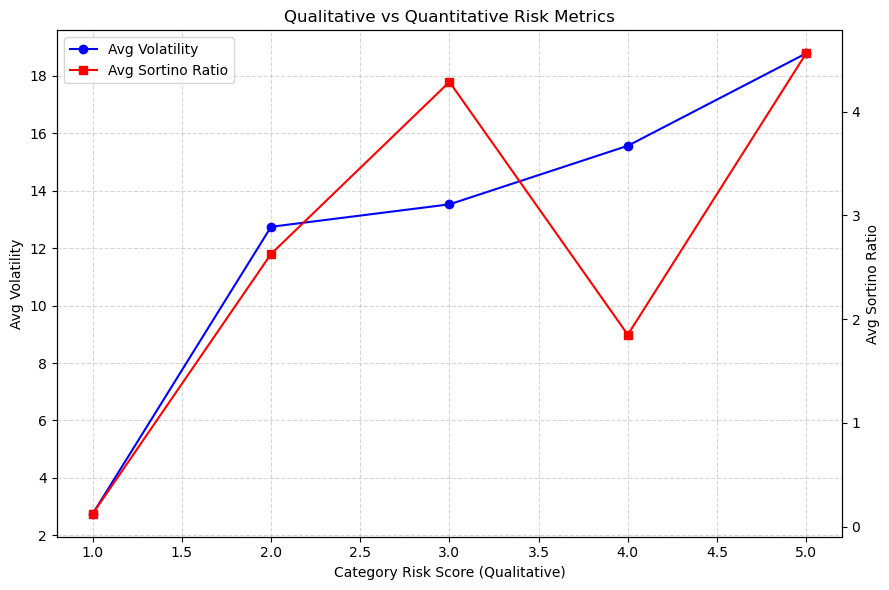

   Category Risk  Fund Count  avg_return  volatility  sortino_ratio
0            1.0          95    7.109576    2.750221       0.125133
1            2.0          77   20.079893   12.745164       2.629463
2            3.0         200   22.083007   13.527519       4.287910
3            4.0         105   19.805693   15.567541       1.850848
4            5.0          90   27.522139   18.787749       4.563187


In [8]:
import matplotlib.pyplot as plt

# Average of quantitative metrics for each qualitative risk category : 
preview = fund_metadata[[
    "ISIN",
    "DERIVED_CATEGORY",
    "category_risk_score",
    "avg_return",
    "volatility",
    "sortino_ratio"
]]

summary = preview.groupby("category_risk_score").agg({
    "ISIN": "count",
    "avg_return": "mean",
    "volatility": "mean",
    "sortino_ratio": "mean"
}).reset_index()



# Plotting Qualitative Risk against both, Volatility(Std dev) and Sortino Ratio
fig, ax1 = plt.subplots(figsize=(9, 6))

#  Volatility :
line1, = ax1.plot(
    summary["category_risk_score"],
    summary["volatility"],
    marker="o", color="blue", label="Avg Volatility"
)
ax1.set_xlabel("Category Risk Score (Qualitative)")
ax1.set_ylabel("Avg Volatility")
ax1.tick_params(axis="y")
ax1.grid(True, which='both', linestyle='--', alpha=0.5)

# Sortino Ratio (Right axis)
ax2 = ax1.twinx()
line2, = ax2.plot(
    summary["category_risk_score"],
    summary["sortino_ratio"],
    marker="s", color="red", label="Avg Sortino Ratio"
)
ax2.set_ylabel("Avg Sortino Ratio")
ax2.tick_params(axis="y")

# Plot
lines = [line1, line2]
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc="upper left")

plt.title("Qualitative vs Quantitative Risk Metrics")
fig.tight_layout()
plt.show()


# Printing Table as well
summary.rename(
    columns={
        'ISIN': 'Fund Count'    },
    inplace=True
)

summary = summary.sort_values("category_risk_score")
summary.rename(
    columns={
        "category_risk_score": "Category Risk",
        'ISIN': 'Fund Count'    },
    inplace=True
)

print(summary)


**Insight:**
1. Qualitative risk score correlates well with volatility and return. As Category Risk increases, both Average Return and Average Volatility increase. 
<br>
2. Sortino ratio peaks for Category Risk : 3,5. 
<br>
3.Sortino Ratio measures return per unit of downside risk.
Higher Sortino implies better risk-adjusted return. Therefore category with  `qualitative risk_score` in {3,5}  seem to have highest risk adjusted return.


Thus, we can conclude : <br>
Qualitative Risk $\propto$ Avg Volatility  ,Avg Return  <br>
Sortino Ratio highest at highest at Medium Risk and Very Hight Risk Categories

## 3. Portfolio Rebalancing: 
Since we have defined our risk model, now we move to Portfolio Rebalancing. We approach this with 3 methods: 

1. Rebalancing via Qualitative Risk Only: <br>
<br>
2. Rebalancing via Quantitative Risk : <br>
<br>
2a. Mean Variance Optimiser (MVO) with Quantitative Risk <br>
2b Conditional Value at Risk (CVaR) with Quantitative Risk<br>
2c. Rebalancing via Hybrid Risk : CVaR with Hybrid Risk 




### Phase 1: Rebalancing via only Qualitative Risk

We Optimize the portfolio returns within each qualitative risk group, by restricting the rebalance within the category of risk as defined above, and thus keeping the overall qualitative risk constant.
<br>
<br>
For each `category_risk_score` group (1–5):
1. We compute total amount invested in that group
2. Rank funds held within the group by performance (`avg_return`)
3. Reallocate entire amount to top 1–2 funds
4. Output new suggested weights per ISIN


Let $ C \in \{1, 2, 3, 4, 5\} $ be the category risk score.

For each user $ u $ and each category $ C $ `scheme`, we want to:

1. Preserve total invested amount in each category:
   $
   \sum_{i \in C_j} A_{u,i} = \text{constant} = $S_j$
   $
   where $ A_{u,i} $ is the amount invested by user $ u $ in fund $ i $ in category $j$

2. Reallocate within category to top performing funds, using our computed expected (Avg) returns: Maximise Expected Returns (Avg Returns) within category

3. Allocate the entire amount to top $ k $ funds (ranked by best `Avg Returns` within that category. We take $k=2$ (For diversification within category as well)


**Current Portfolio for User1(my user)**

In [9]:
# Merging with metadata
scheme_with_meta = scheme.merge(
    fund_metadata[["ISIN", "category_risk_score", "avg_return"]],
    on="ISIN", how="inner"
)

# Filter for the specific user
my_scheme = scheme_with_meta.query("USER_ID == @my_user_id").copy()


# 1. Current Portfolio Overview

print(" My Current Portfolio (Scheme-Level) ")

portfolio_view = (
    my_scheme[["ISIN", "FUND_NAME", "DERIVED_CATEGORY", "category_risk_score", "avg_return", "total_amount_invested"]]
    .sort_values(["category_risk_score", "avg_return"], ascending=[True, False])
    .reset_index(drop=True)
)
display(portfolio_view.style.format({
    "category_risk_score": "{:.2f}",
    "avg_return": "{:.2f}",
    "total_amount_invested": "₹{:,.0f}"
}))


# 2. Portfolio Summary by Category

current_by_cat = (
    my_scheme.groupby("category_risk_score", as_index=False)
    .agg(
        total_investment=("total_amount_invested", "sum"),
        avg_return=("avg_return", "mean")
    )
)

print("\nPortfolio Summary by Category ")
display(current_by_cat.style.format({
    "category_risk_score": "{:.2f}",
    "avg_return": "{:.2f}",
    "total_investment": "₹{:,.0f}"
}))



UndefinedVariableError: local variable 'my_user_id' is not defined

In [ ]:
# Rebalancing using Qualitative Risk  

# Within each risk category, pick top K performing funds by average return
top_k = 2

top_funds = (
    my_scheme.sort_values(["category_risk_score", "avg_return"], ascending=[True, False])
    .groupby("category_risk_score")
    .head(top_k)
    .copy()
)

# Compute category-level totals for scaling
category_totals = (
    my_scheme.groupby("category_risk_score")["total_amount_invested"]
    .sum().reset_index()
)

top_funds = top_funds.merge(category_totals, on="category_risk_score", how="left")

# Allocate within each category based on normalized average returns
top_funds["score_weight"] = (
    top_funds["avg_return"] /
    top_funds.groupby("category_risk_score")["avg_return"].transform("sum")
)
top_funds["new_amount"] = top_funds["score_weight"] * top_funds["total_amount_invested_y"]

# Rebalanced Portfolio
print("\n### Recommended Portfolio After Qualitative Rebalancing ###")

new_portfolio = (
    top_funds[["ISIN", "FUND_NAME", "category_risk_score", "avg_return", "score_weight", "new_amount"]]
    .sort_values(["category_risk_score", "avg_return"], ascending=[True, False])
    .reset_index(drop=True)
)

display(new_portfolio.style.format({
    "category_risk_score": "{:.2f}",
    "avg_return": "{:.2f}",
    "score_weight": "{:.2%}",
    "new_amount": "₹{:,.0f}"
}))


# Portfolio Summary
new_summary = pd.DataFrame({
    "total_investment": [new_portfolio["new_amount"].sum()],
    "avg_return": [new_portfolio["avg_return"].mean()]
})

print("\n New Portfolio Summary (Post-Rebalance) ")
display(new_summary.style.format({
    "total_investment": "₹{:,.0f}",
    "avg_return": "{:.2f}"
}))

#### Conclusion: Qualitative Risk Model only

We were able to identify 4% in missed gains. 25->29%  (By rebalancing to top 2 funds in each risk category) (based on 3 years backtested data)


Therefore it can be concluded that keeping overall risk constant (qualitative risk), we can easily reallocate the funds.


###  Phase 2. Rebalance using Quantitative Risk and Hybrid Risk (Quantitative + Qualtiative Risk)
We move to our hybrid model for evaluating risk. 

We take Overall risk (Qualitative+quantiative)  as we have defined in our`metadata` dataframe as `overall_risk_score` earlier

1. Qualitative Risk (Qualitative- above risk score)
2. Avg Volatility   (Quantitative)
3. Inverse Sortino  (Quantitative)

We normalize all 3 and define `overall_risk_score` as weighted average of 3, with weights<br>
a, b, c = 0.4, 0.3, 0.3

In [10]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Initialize MinMaxScaler for normalization
scaler = MinMaxScaler()

# 1. Normalize volatility
fund_metadata['volatility_norm'] = scaler.fit_transform(fund_metadata[['volatility']])

# 2. Inverse Sortino (lower Sortino = higher risk → higher inverse)
fund_metadata['sortino_inverse'] = 1 / (fund_metadata['sortino_ratio'] + 1e-6)  # to avoid division by zero
fund_metadata['sortino_norm'] = scaler.fit_transform(fund_metadata[['sortino_inverse']])

# Our weights (we can set )
a, b, c = 0.4, 0.3, 0.3  # Weights to balance each factor

# blended risk score (combining normalized volatility, inverse Sortino, and category risk)
fund_metadata['final_risk_score'] = (
    a * fund_metadata['volatility_norm'] + 
    b * fund_metadata['sortino_norm'] +
    c * fund_metadata['category_risk_score']
)

# Now, Calculating final risk score : Hybrid risk
fund_metadata[['ISIN', 'final_risk_score', 'volatility_norm', 'sortino_norm', 'category_risk_score']].head()


C:\Users\Shaurya\anaconda3\lib\site-packages\sklearn\utils\__init__.py:21: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 1.21.5)
  from scipy.sparse import issparse


,ISIN,final_risk_score,volatility_norm,sortino_norm,category_risk_score
0,INF740K01K81,1.115384,0.121996,0.555285,3.0
1,INF204KC1BO3,1.771971,0.264279,0.554198,5.0
2,INF204K01B08,1.132112,0.164584,0.554260,3.0
3,INF174K01LW4,1.432336,0.173199,0.543523,4.0
4,INF760K01KI1,1.161413,0.237966,0.554088,3.0


### Phase 2A: Classical Mean-Variance Optimization (MVO)

MVO will help us optimize user's existing mutual fund portfolio by adjusting the allocation weights across currently held ISINs.TO maximize expected return while minimizing portfolio risk (same or less risk), following the Markowitz Mean-Variance Optimization (MVO) framework.

*Note:* We do **not** introduce any new funds — optimization is performed **only over the user’s existing mutual fund holdings**.



MVO quadratic program: Maximise 



$$
\max_{\mathbf{w}} \quad \mu^\top \mathbf{w} - \lambda \cdot \mathbf{w}^\top \Sigma \mathbf{w}
$$


with constraints: 

$$
\sum_{i=1}^n w_i = 1 \quad \text{(fully invested)}
$$

$$
w_i \geq 0 \quad \forall i \quad \text{(no short-selling)}
$$

where
- $ \mathbf{w} \in \mathbb{R}^n $: Portfolio weight vector (decision variable)  
- $ \mu \in \mathbb{R}^n $: Expected returns for each fund  
- $ \Sigma \in \mathbb{R}^{n \times n} $: Covariance matrix of fund returns  
- $ \lambda \in \mathbb{R}^+ $: Risk aversion parameter ( λ (lambda), to tune the optimization)


- **Covariance matrix** ($ \Sigma $): Derived empirically from the trailing 1-year returns stored in `nav_daily["ONE_YEAR"]`.

  $$
  \Sigma_{ij} = \text{Cov}(R_i^{(1\text{Y})}, R_j^{(1\text{Y})})
  $$



**Summarising** :  Maximise higher expected return (mu · w) and lower risk lower risk (wᵀ Σ w).


Also: each new weight ≥ 25% of current weight (avoid tiny residuals)



#### Notes
- This phase provides a **baseline**: can we improve performance by simply reallocating across existing holdings?
- No new funds are introduced and no switching cost, tax impact, or exit load is modeled.
- We will also plot the efficient frontier 

In [19]:
%pip install cvxpy

     ---------------------------------------- 1.1/1.1 MB 3.6 MB/s eta 0:00:00
     ---------------------------------------- 7.5/7.5 MB 25.1 MB/s eta 0:00:00
     ------------------------------------- 887.3/887.3 kB 27.4 MB/s eta 0:00:00
     ------------------------------------- 301.9/301.9 kB 18.2 MB/s eta 0:00:00
     ---------------------------------------- 46.2/46.2 MB 6.2 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.9.1
    Uninstalling scipy-1.9.1:
      Successfully uninstalled scipy-1.9.1
Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pyquil 3.5.4 requires tenacity<9.0.0,>=8.2.2, but you have tenacity 9.0.0 which is incompatible.


In [13]:
import cvxpy as cp
import matplotlib.pyplot as plt


# Make user_scheme dataframe as we did before, and join metadata to scheme (For my user)
user_scheme = scheme[scheme["USER_ID"] == my_user_id]

# Merge with fund metadata for avg_return and volatility
user_portfolio = user_scheme.merge(
    fund_metadata[["ISIN", "FUND_NAME", "avg_return", "volatility"]],
    on="ISIN", how="left"
)
user_portfolio = user_portfolio.dropna(subset=["avg_return", "volatility"])


# Calculating total invested and current weights
total_invested = user_portfolio["total_amount_invested"].sum()
user_portfolio["current_weight"] = user_portfolio["total_amount_invested"] / total_invested


# Final ISIN list for the user. We need this to build covariance matrix.
user_isins = user_portfolio["ISIN"].tolist()

## For CoV Matrix
returns_matrix = nav_daily[nav_daily["ISIN"].isin(user_isins)].pivot_table(
    index="NAV_DATE", columns="ISIN", values="ONE_YEAR"
).dropna()

returns_matrix = returns_matrix[user_isins]


In [14]:
# :#2A : Classical MVO
# Defining Parameters for MVO

# : Mean returns Matrix (mu) and covariance matrix (Sigma) for MVO
mu = user_portfolio.set_index("ISIN").loc[user_isins]["avg_return"].values  # Expected returns
Sigma = returns_matrix.cov().values  # Covariance matrix (volatility and correlations)


# Setting up Classical MVO 
n = len(user_isins)
w = cp.Variable(n, nonneg=True)  # Non-negative weights (no shorting)

# Risk-aversion parameter (set at 0.1)
risk_aversion = 0.10  # Higher risk_aversion => lower risk, lower risk_aversion => higher return


# Minimum weight constraint: Avoid tiny positions (25% of original weights)
original_weights = user_portfolio.set_index("ISIN").loc[user_isins]["current_weight"].values
min_weights = 0.10 * original_weights



# Now we define Objective function and constraints for MVO
objective = cp.Maximize(mu @ w - risk_aversion * cp.quad_form(w, Sigma))
# Constraints: fully invested (sum of weights = 1), no short selling (w_i >= 0)
constraints = [
    cp.sum(w) == 1,  # Fully invested
    w >= min_weights  # Minimum weight constraint (25% of current weight)
]
prob = cp.Problem(objective, constraints)
_ = prob.solve(solver=cp.SCS, verbose=False)

#  optimized weights
optimized_weights_mvo = np.array(w.value).ravel()

# Output
optimized_mvo = pd.DataFrame({
    "ISIN": user_isins,
    "MVO Optimized Weights": optimized_weights_mvo,
        "avg_return": mu

    
}).merge(user_scheme[["ISIN", "FUND_NAME"]], on="ISIN", how="left")


print("Classical MVO Optimized Weights:")
display(optimized_mvo)


Classical MVO Optimized Weights:


,ISIN,MVO Optimized Weights,avg_return,FUND_NAME
0,INF109K016L0,0.013175,22.222009,ICICI Prudential Bluechip Direct Growth
1,INF179K01YS4,0.008983,27.232102,HDFC ELSS Tax saver Direct Growth
2,INF194KB1CR7,0.003594,19.100597,Bandhan Nifty 100 Index Fund Direct Growth
3,INF204K01XF9,0.189478,30.885654,Nippon India Multi Cap Direct Growth
4,INF204K01XI3,0.476017,25.271565,Nippon India Large Cap Direct Growth
5,INF247L01445,0.024861,38.667818,Motilal Oswal Midcap Direct Growth
6,INF761K01DM6,0.019762,24.729966,Bank of India Mid & Small Cp Eq & Debt Direct ...
7,INF879O01027,0.256944,23.045884,Parag Parikh Flexi Cap Fund Direct Growth
8,INF966L01986,0.007186,26.006061,Quant ELSS Tax Saver Direct Growth


### 2B : Conditional Value-at-Risk (CVaR) Optimization using Quantitative Risk  

While Mean–Variance Optimization (MVO) minimizes overall variance, it does not adequately capture **extreme downside losses**.  
The **Conditional Value-at-Risk (CVaR)** model, also known as *Expected Shortfall*, is designed to address this limitation by focusing explicitly on the **tail of the return distribution** — i.e., the worst-case outcomes.

---

#### Definition  

At confidence level $ \alpha $, the Conditional Value-at-Risk is defined as:  

$$
\text{CVaR}_\alpha = \mathbb{E}[L \mid L \geq \text{VaR}_\alpha]
$$

where  

- $ L $ : Portfolio loss (negative return)  
- $ \text{VaR}_\alpha $ : Value-at-Risk at confidence level $ \alpha $ (e.g., 95% or 99%)  

Intuitively, CVaR represents the **average loss** beyond the Value-at-Risk threshold — a measure of the expected “worst-case” loss.  

---

#### Optimization   

The Mean–CVaR portfolio optimization problem can be expressed as:

$$
\begin{aligned}
\max_{\mathbf{w}, \, \text{VaR}, \, \mathbf{z}} \quad &
\lambda_{\text{CVaR}} \, (\mu^\top \mathbf{w})
- (1 - \lambda_{\text{CVaR}}) \left[
\text{VaR} + \frac{1}{T(1-\alpha)} \sum_{t=1}^T z_t
\right] \\
\text{s.t.} \quad &
\sum_{i=1}^{n} w_i = 1, \quad w_i \ge 0 \\
& z_t \ge 0, \quad z_t \ge - (r_t^\top \mathbf{w} - \text{VaR}) \quad \forall t
\end{aligned}
$$

where:  

- $ \mu $ expected returns for each fund  
- $ r_t $: vector of realized returns on day $t$  
- $ z_t $ auxiliary variable representing tail losses  
- $ \text{VaR} $: Value-at-Risk variable (quantile cutoff)  
- $ \alpha $: confidence level (typically 0.95)  
- $ \lambda_{\text{CVaR}} \in [0,1] $: tradeoff between maximizing returns and minimizing tail risk  

This formulation is **linear** and can be efficiently solved using linear programming (LP) solvers such as ECOS, SCS, or GUROBI.  

---


In [ ]:
import cvxpy as cp
import numpy as np
import pandas as pd

# Step 1: Data Setup (same returns_matrix and expected returns mu as in MVO)
portfolio_returns_matrix = returns_matrix.values
num_days, n_assets = portfolio_returns_matrix.shape

# Step 2: Define optimization variables
w_cvar = cp.Variable(n_assets)     # portfolio weights
VaR = cp.Variable()                # Value-at-Risk (quantile cutoff)
z = cp.Variable(num_days)          # auxiliary losses (>= 0)

# Step 3: Define constants
alpha = 0.95                       # confidence level (CVaR 95%)
lambda_cvar = 0.5                  # trade-off between mean return and tail risk
min_weights = 0                    # optional lower bound for holdings

# Step 4: Define portfolio daily returns
portfolio_daily_returns = portfolio_returns_matrix @ w_cvar

# Step 5: Define constraints
constraints = [
    cp.sum(w_cvar) == 1,           # fully invested
    w_cvar >= min_weights,         # no short-selling
    z >= 0,
    z >= -(portfolio_daily_returns - VaR)
]

# Step 6: Define objective function (Rockafellar–Uryasev formulation)
objective = cp.Maximize(
    lambda_cvar * (mu @ w_cvar) -
    (1 - lambda_cvar) * (VaR + (1 / ((1 - alpha) * num_days)) * cp.sum(z))
)

# Step 7: Solve optimization
problem = cp.Problem(objective, constraints)
problem.solve(solver=cp.ECOS, verbose=False)

# Step 8: Extract optimized weights
optimized_weights_cvar = np.array(w_cvar.value).ravel()

# Step 9: Display results
cvar_optimized = (
    pd.DataFrame({
        "ISIN": user_isins,
        "Optimized_Weight_CVaR": optimized_weights_cvar,
        "Expected_Return": mu
    })
    .merge(user_scheme[["ISIN", "FUND_NAME"]], on="ISIN", how="left")
    .sort_values("Optimized_Weight_CVaR", ascending=False)
)

print("✅ CVaR Optimization Results (95% confidence)")
display(cvar_optimized.style.format({
    "Optimized_Weight_CVaR": "{:.2%}",
    "Expected_Return": "{:.2f}"
}))


### **Phase 2C: Conditional Value-at-Risk (CVaR) with Hybrid Risk Penalization**

This phase extends the CVaR model by adding a **hybrid risk penalty**, which combines both qualitative and quantitative risk measures.

CVaR (Conditional Value-at-Risk) measures the **expected loss beyond the Value-at-Risk (VaR)** threshold, capturing tail risk more effectively:

$$
\text{CVaR}_\alpha = \mathbb{E}[X \mid X \leq \text{VaR}_\alpha]
$$

**Objective Function:**

$$
\max_{\mathbf{w}} \; \mu^\top \mathbf{w} 
- \lambda_{\text{CVaR}} \cdot \mathbb{E}[\text{CVaR}] 
- \lambda_{\text{hybrid}} \cdot \sum_i w_i \cdot R_i
$$

where:  
- $ \mu^\top \mathbf{w} $ — expected portfolio return  
- $ \mathbb{E}[\text{CVaR}] $ — expected tail loss (downside risk)  
- $ R_i $ — hybrid risk score for asset *i*  
- $ \lambda_{\text{CVaR}} $, $ \lambda_{\text{hybrid}} $ — penalty coefficients for tail and hybrid risk  



In [17]:
 #2c : CVAR   (Hybrid Risk)

#  hybrid risk score for each ISIN
final_risk_score = fund_metadata.set_index("ISIN").loc[user_isins]["final_risk_score"].values


# CVaR optimization variables
portfolio_returns_matrix = returns_matrix.values
num_days, n_assets = portfolio_returns_matrix.shape

w_cvar = cp.Variable(n_assets)
VaR = cp.Variable()
z = cp.Variable(num_days)

# Portfolio daily returns
portfolio_daily_returns = portfolio_returns_matrix @ w_cvar

# Constraints: CVaR and hybrid risk
constraints_cvar_hybrid = [
    cp.sum(w_cvar) == 1,  # Fully invested
    w_cvar >= min_weights,  # No short selling
    z >= 0,  # Losses are non-negative
    z >= -(portfolio_daily_returns - VaR),  # CVaR calculation
]



lambda_cvar = 0.1  # Penalty for CVaR
lambda_hybrid_cvar = 0.05  # Penalty for hybrid risk

# Objective: maximize return - penalize CVaR - penalize hybrid risk score
objective_cvar_hybrid = cp.Maximize(mu @ w_cvar - lambda_cvar * cp.sum(z) / (num_days) - lambda_hybrid_cvar * cp.sum(final_risk_score * w_cvar))


prob_cvar_hybrid = cp.Problem(objective_cvar_hybrid, constraints_cvar_hybrid)
prob_cvar_hybrid.solve(solver=cp.SCS, verbose=False)


#SOlving 
optimized_weights_cvar_hybrid = np.array(w_cvar.value).ravel()


cvar_hybrid_result = pd.DataFrame({
    "ISIN": user_isins,
    "optimized_weight_cvar_hybrid": optimized_weights_cvar_hybrid,
    "final_risk_score": final_risk_score,
    "avg_return": mu
})

cvar_hybrid_result = cvar_hybrid_result.merge(user_scheme[["ISIN", "FUND_NAME"]], on="ISIN", how="left")

cvar_hybrid_result = cvar_hybrid_result.sort_values("optimized_weight_cvar_hybrid", ascending=False)

print("\n== 2c) CVaR + Hybrid Risk Penalization — Optimized Weights ==")
display(cvar_hybrid_result)



== 2c) CVaR + Hybrid Risk Penalization — Optimized Weights ==


C:\Users\Shaurya\anaconda3\lib\site-packages\cvxpy\expressions\expression.py:683: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 2 times so far.

  warnings.warn(msg, UserWarning)


,ISIN,optimized_weight_cvar_hybrid,final_risk_score,avg_return,FUND_NAME
5,INF247L01445,0.914379,1.203254,38.667818,Motilal Oswal Midcap Direct Growth
4,INF204K01XI3,0.023946,0.850152,25.271565,Nippon India Large Cap Direct Growth
6,INF761K01DM6,0.019765,1.189553,24.729966,Bank of India Mid & Small Cp Eq & Debt Direct ...
0,INF109K016L0,0.013172,0.855806,22.222009,ICICI Prudential Bluechip Direct Growth
1,INF179K01YS4,0.008978,1.160423,27.232102,HDFC ELSS Tax saver Direct Growth
8,INF966L01986,0.007178,1.210849,26.006061,Quant ELSS Tax Saver Direct Growth
7,INF879O01027,0.005997,1.165923,23.045884,Parag Parikh Flexi Cap Fund Direct Growth
2,INF194KB1CR7,0.003596,0.845246,19.100597,Bandhan Nifty 100 Index Fund Direct Growth
3,INF204K01XF9,0.002989,1.165825,30.885654,Nippon India Multi Cap Direct Growth


### Output Comparisons and Efficient Frontier: 

In [50]:
user_scheme = scheme[scheme["USER_ID"] == my_user_id]

# Merge with fund metadata for avg_return, volatility, and final risk
user_scheme_merged = user_scheme.merge(
    fund_metadata[["ISIN", "FUND_NAME", "avg_return", "volatility", "final_risk_score"]],
    on="ISIN",
    how="inner"
)

# Compute current weights
total_invested = user_scheme_merged["total_amount_invested"].sum()
current_weights = user_scheme_merged["total_amount_invested"] / total_invested


In [70]:
# We define a compute function which gives portfolio returns and risk measures when fed with weights to each fund in the portfolio 

def compute_portfolio_metrics(weights, mu, Sigma):
    port_return = np.dot(weights, mu)
    port_risk = np.sqrt(weights.T @ Sigma @ weights)
    sharpe = port_return / port_risk if port_risk > 0 else 0
    return port_return, port_risk, sharpe


 #Computes summary: expected return, volatility, and avg risk score
def compute_summary(user_scheme_merged, optimized_weights, Sigma, portfolio_name="Portfolio"):
    mu = user_scheme_merged.set_index("ISIN").loc[user_scheme_merged["ISIN"], "avg_return"].values
    final_risk = user_scheme_merged.set_index("ISIN").loc[user_scheme_merged["ISIN"], "final_risk_score"].values
    
    port_return, port_risk, _ = compute_portfolio_metrics(optimized_weights, mu, Sigma)
    avg_risk_score = np.dot(optimized_weights, final_risk)
    
    return {
        "portfolio_name": portfolio_name,
        "avg_return": port_return,
        "volatility": port_risk,
        "avg_risk_score": avg_risk_score
    }


In [90]:
# Reevaluatng covariance matrix from returns_matrix for efficient frontier comparisons
Sigma = returns_matrix.cov().values
mu = user_scheme_merged.set_index("ISIN").loc[user_scheme_merged["ISIN"], "avg_return"].values

# Current
current_summary = compute_summary(user_scheme_merged, current_weights, Sigma, "Current Portfolio")

# Classical MVO
mvo_summary = compute_summary(user_scheme_merged, optimized_weights_mvo, Sigma, "MVO Portfolio")


# CVaR  
cvar_summary = compute_summary(user_scheme_merged, optimized_weights_cvar, Sigma, "CVaR Portfolio")


# Hybrid risk CVaR
cvar_hybrid_summary = compute_summary(user_scheme_merged, optimized_weights_cvar_hybrid, Sigma, "CVaR + Hybrid Portfolio")


# Equal weight portfolio case:   We also define and compare with equal weight portfolio case:
n_assets = len(mu)
equal_weights = np.repeat(1/n_assets, n_assets)
inv_vol = 1 / np.sqrt(np.diag(Sigma))
equal_summary = compute_summary(user_scheme_merged, equal_weights, Sigma, "Equal Weight Portfolio")


# Display all summaries
import pandas as pd
summary_df = pd.DataFrame([current_summary, mvo_summary,cvar_summary, mvo_hybrid_summary, cvar_hybrid_summary,equal_summary])
display(summary_df)


# x = volatility, y = avg_return
portfolio_risks = summary_df["volatility"]
portfolio_returns = summary_df["avg_return"]
portfolio_labels = summary_df["portfolio_name"]


,portfolio_name,avg_return,volatility,avg_risk_score
0,Current Portfolio,26.729991,14.537198,1.050680
1,MVO Portfolio,26.046321,12.340860,1.012022
2,CVaR Portfolio,37.559386,19.128181,1.191425
3,MVO Hybrid Portfolio,37.474049,19.074173,1.187997
4,CVaR + Hybrid Portfolio,37.474052,19.074167,1.187998
5,Equal Weight Portfolio,26.351295,14.522726,1.071892


#### Efficient Frontier: 

In [86]:
# We define efficient frontier function
def efficient_frontier(mu, Sigma, n_points=50):
    n = len(mu)
    risks, returns = [], []

    for risk_aversion in np.linspace(0.01, 0.5, n_points):
        w = cp.Variable(n, nonneg=True)
        objective = cp.Maximize(mu @ w - risk_aversion * cp.quad_form(w, Sigma))
        constraints = [cp.sum(w) == 1]
        prob = cp.Problem(objective, constraints)
        prob.solve(solver=cp.SCS, verbose=False)
        if w.value is not None:
            w_opt = np.array(w.value).ravel()
            port_return = np.dot(w_opt, mu)
            port_risk = np.sqrt(w_opt.T @ Sigma @ w_opt)
            returns.append(port_return)
            risks.append(port_risk)
    return np.array(risks), np.array(returns)



Sigma = returns_matrix.cov().values
mu = user_scheme_merged.set_index("ISIN").loc[user_scheme_merged["ISIN"], "avg_return"].values

risks_frontier, returns_frontier = efficient_frontier(mu, Sigma)


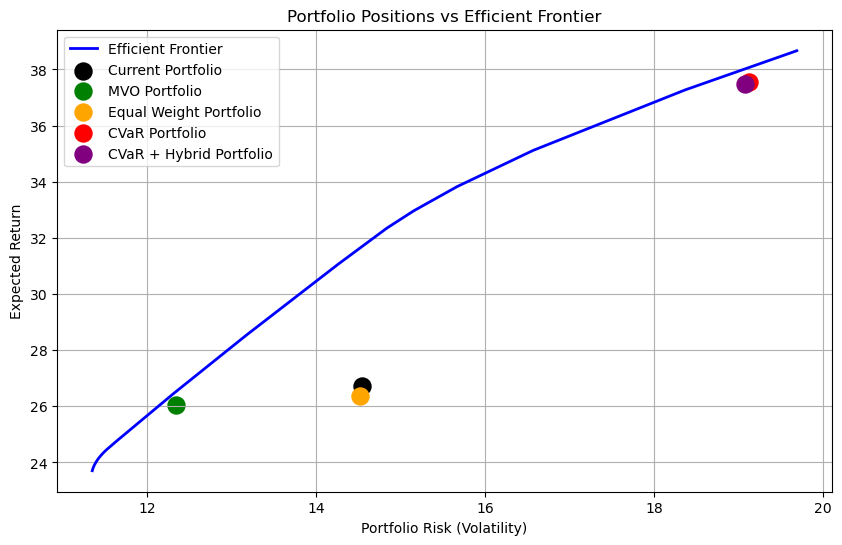

In [87]:
plt.figure(figsize=(10,6))

# Efficient frontier
plt.plot(risks_frontier, returns_frontier, color="blue", linewidth=2, label="Efficient Frontier")

colors = ["black", "green", "orange", "red", "purple"]
for i, label in enumerate(portfolio_labels):
    plt.scatter(portfolio_risks[i], portfolio_returns[i], color=colors[i], s=150, label=label)

plt.xlabel("Portfolio Risk (Volatility)")
plt.ylabel("Expected Return")
plt.title("Portfolio Positions vs Efficient Frontier")
plt.legend()
plt.grid(True)
plt.show()


1. Clasical MVO portfolio lowers volatility  compared to the current portfolio, with but reduces average return. Since classical MVO penalizes only volatility,  reduces risk but sacrifices returns as well.

2. The MVO + Hybrid Risk and CVaR + Hybrid Risk portfolios show a significant jump in expected returns (~ 11% higher) but come with noticeably higher volatility. Since they penalize downside risk/tail end risk. So, we  get higher returns at cost of volatility but overall downside/tail end risk is very manageed in this. 


If we prefer a safer approach, Classical MVO offers moderate returns with reduced risk.

If we want higher returns and can tolerate more risk, the hybrid risk portfolios might suit you better.

Overall (expected retunrs) : 
Hybrid Risk CVAR> Hybrid Risk MVO > Classical MVO


### Phase 3: Incorporating Fund Switching

In the previous phases, all optimization was performed **within the user's existing portfolio universe**, i.e., rebalancing allocations only across the funds already held.

We have already demonstrated a **fund-switching logic** in the **Phase 1 (Qualitative Risk Model)**, where selection was made for the *top-performing funds within each category* based on their category-level risk score and return profile.


#### **Extending Phase 2 to Fund Switching**

To fully incorporate *fund switching* into the quantitative optimization (MVO or CVaR), we would need to extend the portfolio universe beyond current holdings.

This requires defining the **user’s target risk appetite**, which governs how much additional risk the user is willing to take when introducing new funds.

Conceptually, this expands the optimization problem **beyond the current efficient frontier**, as the feasible set now includes *all available mutual funds* in the market, not just those currently held.  
In mathematical terms, this enlarges the feasible region \( \mathcal{W} \) of portfolio weights to include additional ISINs, resulting in a **shift and extension** of the efficient frontier:

$$
\mathcal{W}_{\text{extended}} = \{\mathbf{w} \in \mathbb{R}^m \mid \sum_{i=1}^{m} w_i = 1, \, w_i \geq 0\}
$$

where \( m > n \) reflects the inclusion of new eligible funds.

---

### **Future Work and Add-Ons**

Currently left as **future work** and can serve as an add-on to the present project.

Incorporating fund switching would involve:
1. Expanding the fund universe to include all funds within the same or adjacent categories.
2. Defining user-specific **risk tolerance parameters** (e.g., conservative, balanced, aggressive) which we can use to optimize for returns
3. Introducing **transaction cost and tax constraints** to ensure practical implementation: 
**LTCG and STCG Tax aware logic** can be added to the model when calculating fund switch. This calls for knowing full transaction history for each portfolios also (Stamp duty set at 0.001%)



In essence, while the current project focuses on **risk-aware rebalancing** within the existing portfolio, incorporating fund switching would move toward **active portfolio optimization** — potentially improving returns but requiring additional modeling of investor preferences, costs, and tax liability in Indian Market to know if it is even worth switching  (**LTCG and STCG Tax**)

We therefore leave this as **future work**, to be built as an extension to the current framework.
